In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from numpy import random
import tensorflow as tf
from tensorflow.keras import layers
mpl.rcParams["font.sans-serif"] = ["SimHei"]
mpl.rcParams["axes.unicode_minus"] = False

In [2]:
def cos_sim(vec1, vec2):
    # cosine simility
    dot = vec1.dot(vec2)
    L2 = np.linalg.norm(vec1)*np.linalg.norm(vec2)
    return dot / L2

def dot_sim(vec1, vec2):
    # dot simility
    dot = vec1.dot(vec2)
    return dot

def wgs84toWebMercator(lon,lat):
    x =  lon*20037508.342789/180
    y =math.log(math.tan((90+lat)*math.pi/360))/(math.pi/180)
    y = y *20037508.34789/180
    return x,y

In [3]:
geo_distance = np.load('./data/geo_distance.npy')
city2id = np.load(r"./data/city2id.npy", allow_pickle=True).item()
id2city = np.load(r"./data/id2city.npy", allow_pickle=True).item()
coordinate_all = pd.read_csv(r"./data/citys_coordinate_wgs84.csv",encoding='utf-8')

In [4]:
n = len(coordinate_all)
vocab_size = n
# 地理距离
distance = np.zeros((n,n),dtype=float)
for i in range(n):
    for j in range(i+1, n):
        distance[i][j] = geo_distance[i][j]
        distance[j][i] = distance[i][j]

# 坐标（经纬度）
coordinate = np.zeros((n,2),dtype=float)
citys_name = []
for i in range(n):
    coordinate[i][0] = coordinate_all.iloc[i][1]
    coordinate[i][1] = coordinate_all.iloc[i][2]
    citys_name.append(coordinate_all.iloc[i][0])

In [5]:
C = np.zeros((n,2))
for i in range(n):
    temp = wgs84toWebMercator(coordinate[i][0], coordinate[i][1])
    C[i][0] = temp[0]; C[i][1] = temp[1]

In [7]:
flow = np.load(r"./data/data_avg.npy")

In [8]:
m = flow.sum(axis=1)

In [9]:
# 流量标准化函数
def T_ij(flow, m):
    # 对流量进行标准化
    flow_re = np.zeros_like(flow)
    j_sum = flow.sum(axis=1)
    for i in range(n):
        flow_re[i,:]= flow[i,:] / j_sum[i] * m[i]
    return flow_re

正样本采集  这里记得优化一下,   优化不了。。 已经是最快的了

In [87]:
# 让每一行的数据归一化
data = pd.DataFrame(flow)
data = data.apply(lambda r:r/r.sum(), axis=1)

# 再计算累积分布
data_cum = np.array(data)
for i in range(1, data_cum.shape[1]):
    data_cum[:,i] = data_cum[:, i-1]+data_cum[:,i]
#pd.DataFrame(data_cum)

# 起点
start_cum= m / m.sum()
for i in range(1, start_cum.shape[0]):
    start_cum[i] = start_cum[i]+start_cum[i-1]
#start_cum

In [88]:
np.random.seed(486626)
targets = [] #(n,)
postive_context = [] #(n,)
target_size = 100000
starts = random.uniform(size=(target_size,2))
for i in range(target_size):
    targets.append(np.searchsorted(start_cum, starts[i][0]))
    postive_context.append(np.searchsorted(data_cum[targets[i]], starts[i][1]))

In [86]:
# 优化方法  没用，更慢了
np.random.seed(486626)
data = pd.DataFrame(flow)
data = np.array(data.apply(lambda r:r/r.sum(), axis=1))
postive_context = [] #(n,)
target_size = 100000
m_p = m/m.sum()
a = list(range(len(m)))
targets = np.random.choice(size=100000, a=a, p = m_p)
postive_context = [np.random.choice(a=a, p = data[target]) for target in targets]

正样本重建网络

In [38]:
data_reconstruct = np.zeros((n,n),dtype=float)
for i in range(target_size):
    data_reconstruct[targets[i]][postive_context[i]]+=1

In [39]:
data_reconstruct_re = T_ij(data_reconstruct, m)
data_reconstruct_re_city = pd.DataFrame(data_reconstruct_re)
data_reconstruct_re_city.columns = citys_name
data_reconstruct_re_city.index = citys_name
data_reconstruct_re_city

,北京市,天津市,石家庄市,唐山市,秦皇岛市,邯郸市,邢台市,保定市,张家口市,承德市,...,喀什地区,和田地区,伊犁哈萨克自治州,塔城地区,阿勒泰地区,石河子市,阿拉尔市,图木舒克市,五家渠市,铁门关市
北京市,0.000000,25.628570,6.543465,5.725531,2.453799,6.816109,1.635866,30.263524,10.087841,8.724619,...,0.000000,0.000000,0.00000,0.000000,0.0,0.272644,0.0,0.000000,0.0,0.0
天津市,28.657782,0.000000,2.553664,21.848012,2.553664,7.660991,1.134962,5.391068,1.702443,2.553664,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
石家庄市,6.530659,3.975184,0.000000,1.419709,0.851825,9.370076,16.468619,18.740153,1.987592,1.135767,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
唐山市,9.394091,25.246621,2.642088,0.000000,10.274787,2.054957,0.587131,3.816350,2.054957,5.871307,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
秦皇岛市,3.092027,1.686560,1.686560,12.087016,0.000000,0.562187,0.000000,0.843280,0.562187,1.405467,...,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
石河子市,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.28537,9.702579,0.0,0.000000,0.0,0.000000,0.0,0.0
阿拉尔市,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.256321,0.00000,0.000000,0.0,0.000000,0.0,0.256321,0.0,0.0
图木舒克市,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.388751,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
五家渠市,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.253666,0.00000,0.253666,0.0,0.000000,0.0,0.000000,0.0,0.0


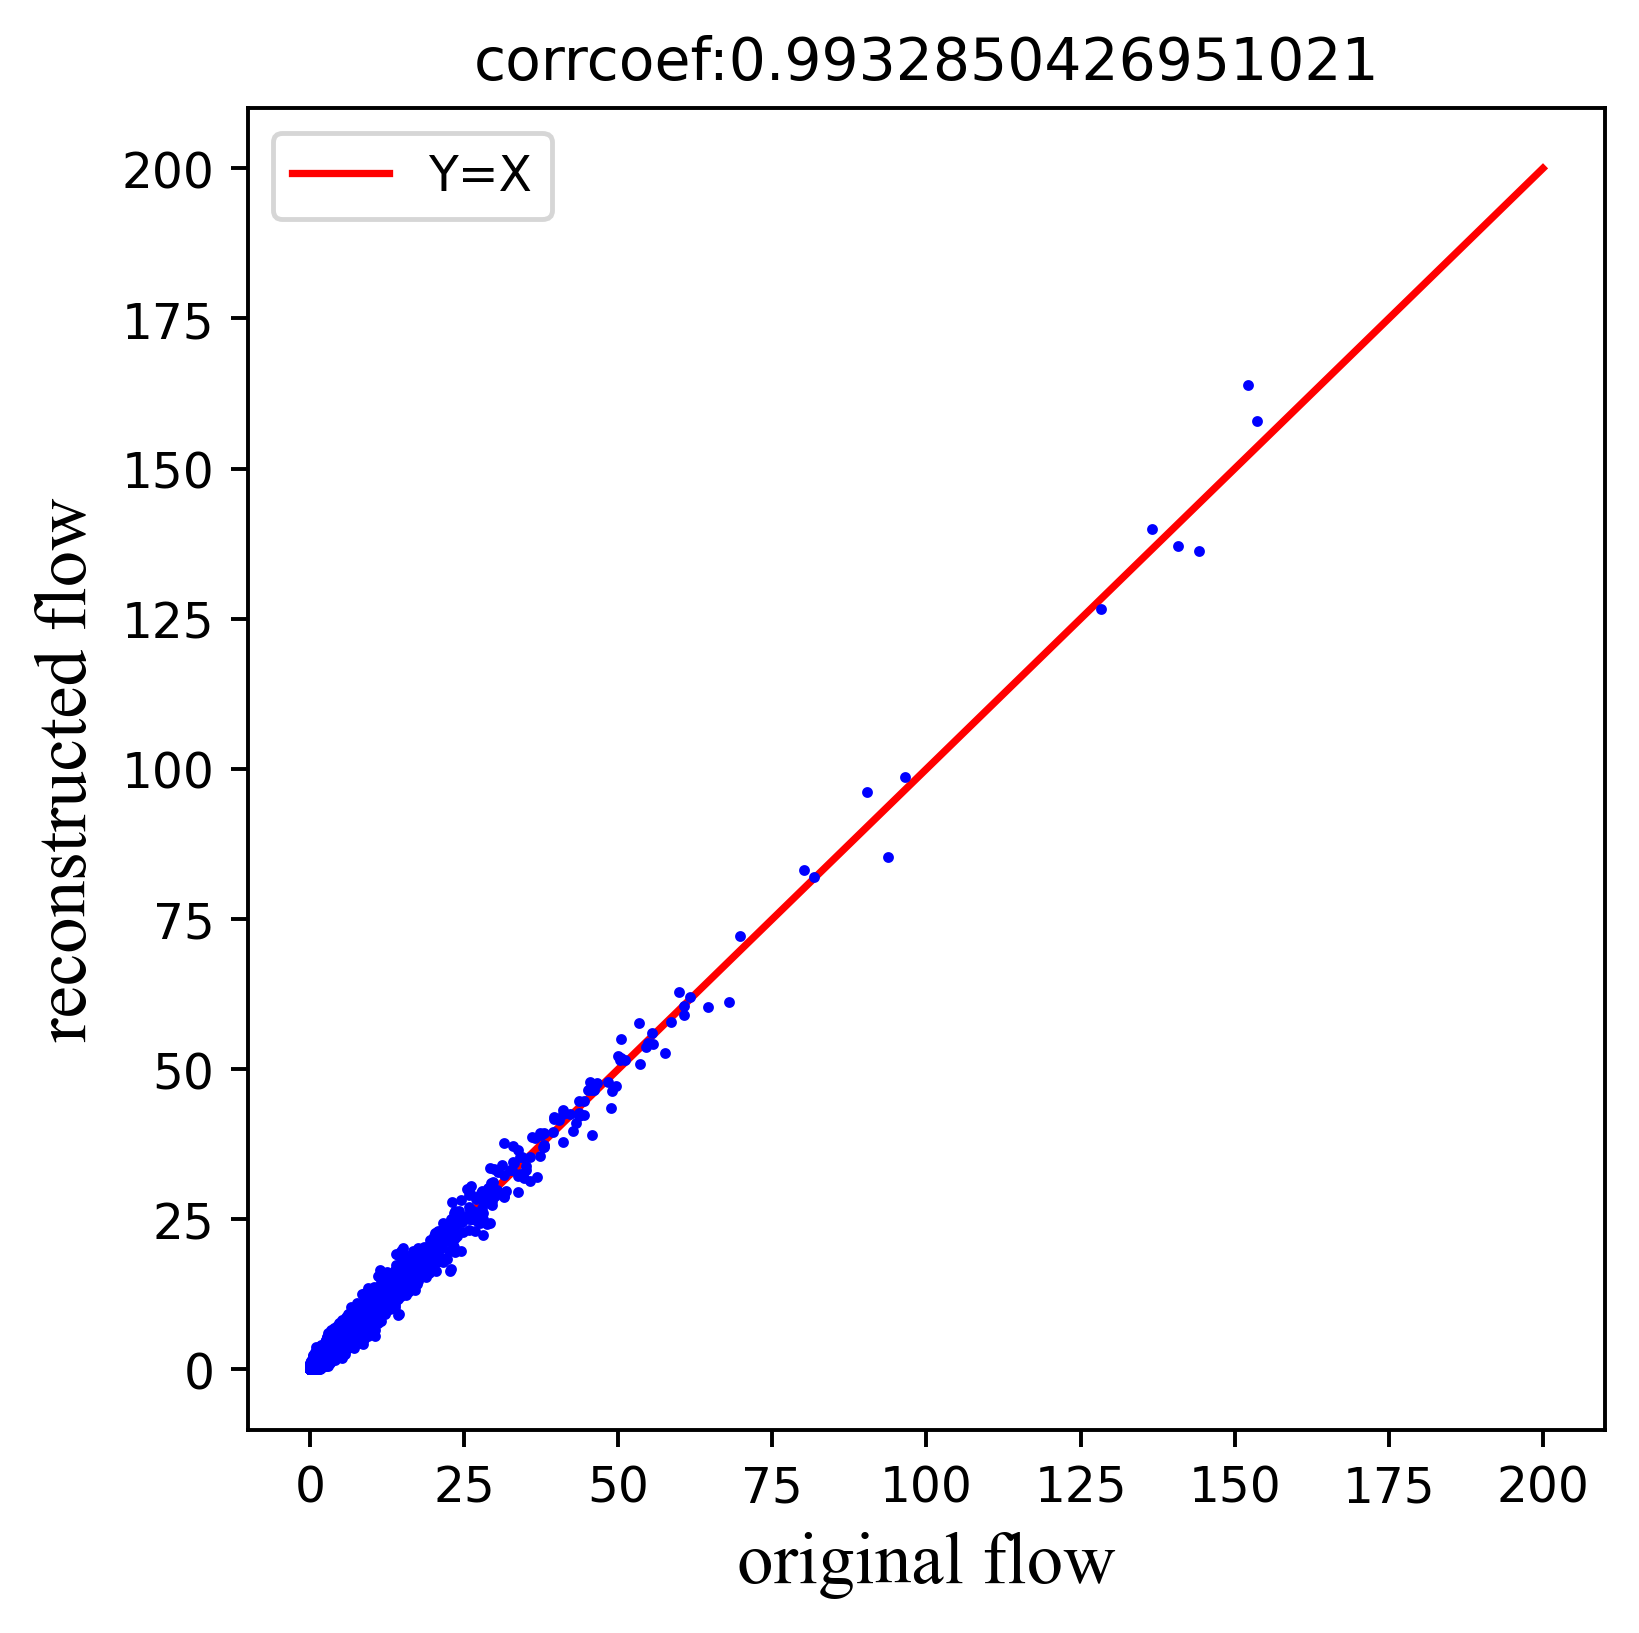

In [40]:
figure, axes =plt.subplots(1,1,figsize=(5,5),dpi=350)
y = data_reconstruct_re.flatten()
x = flow.flatten()
data_plot = pd.DataFrame({'original flow':x,'reconstructed flow':y})
data_plot.plot.scatter(x='original flow', y='reconstructed flow', ax=axes, s=1.5, c='blue')
plt.plot([0,200],[0,200],color='red',zorder=0,label='Y=X')
coef = np.corrcoef([x,y])[0][1]
axes.set_xlabel("original flow", fontdict={'family':'Times New Roman','weight':'normal','size':15})
axes.set_ylabel("reconstructed flow",fontdict={'family':'Times New Roman','weight':'normal','size':15})
plt.title("corrcoef:" +str(coef))
plt.legend()

负样本采样  同样需要优化

In [41]:
start_cum_negative = np.array([m]*vocab_size)
start_cum_negative = np.where(data_reconstruct_re==0, start_cum_negative, 0)
for i in range(vocab_size):
    start_cum_negative[i][i]=0
# 让每一行的数据归一化
start_cum_negative = pd.DataFrame(start_cum_negative)
start_cum_negative = start_cum_negative.apply(lambda r:r/r.sum(), axis=1)

# 再计算累积分布
start_cum_negative = np.array(start_cum_negative)
for i in range(1, start_cum_negative.shape[1]):
    start_cum_negative[:,i] = start_cum_negative[:, i-1]+start_cum_negative[:,i]
#pd.DataFrame(start_cum_negative)

In [42]:
np.random.seed(486626)
negative_sample_size = 5
negative_context = []
rand = random.uniform(size=(target_size,negative_sample_size))
for i in range(target_size):
    negative_context_i = []
    for j in range(negative_sample_size):
        negative_context_temp = np.searchsorted(start_cum_negative[targets[i]], rand[i][j])
        negative_context_i.append(negative_context_temp)
    negative_context.append(negative_context_i)

In [43]:
# 构建完整训练集
labels = []
contexts = []
for i in range(target_size):
    contexts.append([postive_context[i]] + negative_context[i])
    labels.append([1]+[0]*negative_sample_size)

模型训练

In [44]:
# Load the TensorBoard notebook extension  这什么board是不是可以不要？
# %load_ext tensorboard

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

SEED = 486626
AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE = 128
BUFFER_SIZE = 10000
targets_use = np.array(targets, dtype='float32')
contexts_use = np.array(contexts, dtype='float32')
labels_use = np.array(labels, dtype='float32')
dataset = tf.data.Dataset.from_tensor_slices(((targets_use, contexts_use), labels_use))
dataset = dataset.shuffle(BUFFER_SIZE,seed=SEED).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(128,), dtype=tf.float32, name=None), TensorSpec(shape=(128, 6), dtype=tf.float32, name=None)), TensorSpec(shape=(128, 6), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=((TensorSpec(shape=(128,), dtype=tf.float32, name=None), TensorSpec(shape=(128, 6), dtype=tf.float32, name=None)), TensorSpec(shape=(128, 6), dtype=tf.float32, name=None))>


In [25]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=negative_sample_size+1,
                                       name="w2v_context")

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [20]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [45]:
# 更换损失函数
embedding_dim = 100
vocab_size = len(m)
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=custom_loss,
                 metrics=['accuracy'])

In [46]:
word2vec.fit(dataset, epochs=1)

781/781 [==============================] - 2s 2ms/step - loss: -0.7062 - accuracy: 0.8073


In [47]:
# 模型预测


weights_v = word2vec.get_layer('w2v_embedding').get_weights()[0]
weights_u = word2vec.get_layer('w2v_context').get_weights()[0]
X = np.eye(vocab_size)[targets]
Y0 = np.dot(X, weights_v)
L1 = np.linalg.norm(Y0,axis=1)
L2 = np.linalg.norm(weights_u,axis=1)
DOT = np.dot(Y0,weights_u.T)
Y = np.zeros((target_size,vocab_size),dtype=float)
for i in range(target_size):
    for j in range(vocab_size):
        Y[i][j] = DOT[i][j]/(L1[i]*L2[j])
P = np.argmax(Y,axis=1)
data_predicted_P = np.zeros((n,n),dtype=float)
for i in range(target_size):
    data_predicted_P[targets[i]][P[i]]+=1
data_predicted_P_re = T_ij(data_predicted_P, m)
cof1 = np.corrcoef(flow.flatten(), data_predicted_P_re.flatten())[0][1]
print('cof1:',cof1)
#res1.append(cof1)
dot_simility_i = []
cos_simility_i = []
geo = []
for i in range(n):
    for j in range(i+1,n):
        dot_simility_i.append(dot_sim(weights_v[i], weights_v[j]))
        cos_simility_i.append(cos_sim(weights_v[i], weights_v[j]))
        geo.append(distance[i][j])
cof2 = np.corrcoef([dot_simility_i, geo])[0][1]
cof3 = np.corrcoef([cos_simility_i, geo])[0][1]
print('cof2:', cof2)
#res2.append(cof2)
print('cof3:', cof3)

cof1: 0.6498173829308463
cof2: -0.4817585536323197
cof3: -0.5228246926717957


In [48]:
w_max = None
c_max = 0
for pp in range(10):
    embedding_dim = 100
    word2vec = Word2Vec(vocab_size, embedding_dim)
    word2vec.compile(optimizer='adam',
                    loss=custom_loss,
                    metrics=['accuracy'])

    word2vec.fit(dataset, epochs=1)
    weights_v = word2vec.get_layer('w2v_embedding').get_weights()[0]
    weights_u = word2vec.get_layer('w2v_context').get_weights()[0]
    X = np.eye(vocab_size)[targets]
    Y0 = np.dot(X, weights_v)
    L1 = np.linalg.norm(Y0,axis=1)
    L2 = np.linalg.norm(weights_u,axis=1)
    DOT = np.dot(Y0,weights_u.T)
    Y = np.zeros((target_size,vocab_size),dtype=float)
    for i in range(target_size):
        for j in range(vocab_size):
            Y[i][j] = DOT[i][j]/(L1[i]*L2[j])

    P = np.argmax(Y,axis=1)
    data_predicted_P = np.zeros((n,n),dtype=float)
    for i in range(target_size):
        data_predicted_P[targets[i]][P[i]]+=1
    data_predicted_P_re = T_ij(data_predicted_P, m)
    print('cof0:',np.corrcoef(flow.flatten(), data_predicted_P_re.flatten())[0][1])

    dot_simility = np.zeros((n,n),dtype=float)
    cos_simility = np.zeros((n,n),dtype=float)
    for i in range(n):
        for j in range(n):
            if i==j:
                continue
            dot_simility[i][j] = dot_sim(weights_v[i], weights_v[j])
            cos_simility[i][j] = cos_sim(weights_v[i], weights_v[j])

    print('cof1:',np.corrcoef(distance.flatten(), dot_simility.flatten())[0][1])
    print('cof2:',np.corrcoef(distance.flatten(), cos_simility.flatten())[0][1])
    cofff = np.corrcoef(distance.flatten(), cos_simility.flatten())[0][1]
    if abs(cofff)>c_max:
        c_max = abs(cofff)
        w_max = weights_v

781/781 [==============================] - 2s 2ms/step - loss: -0.7262 - accuracy: 0.8059
cof0: 0.6437903062699157
cof1: -0.5294463709350103
cof2: -0.6461438889365478
781/781 [==============================] - 2s 2ms/step - loss: -0.7114 - accuracy: 0.7952
cof0: 0.6501843972409985
cof1: -0.5259375464364405
cof2: -0.6364220698727661
781/781 [==============================] - 2s 2ms/step - loss: -0.6874 - accuracy: 0.8152
cof0: 0.643264393374613
cof1: -0.52387628286806
cof2: -0.6054638342342686
781/781 [==============================] - 2s 2ms/step - loss: -0.6888 - accuracy: 0.8054
cof0: 0.6403936970022249
cof1: -0.5147675118352197
cof2: -0.6179161464908429
781/781 [==============================] - 2s 2ms/step - loss: -0.7655 - accuracy: 0.8007
cof0: 0.651185938122369
cof1: -0.5305148691142718
cof2: -0.6257005448735763
781/781 [==============================] - 2s 2ms/step - loss: -0.7926 - accuracy: 0.7695
cof0: 0.642489185405275
cof1: -0.5185297918353349
cof2: -0.6152136946192116
781

In [50]:
weights_v = w_max

后续数据处理

In [51]:
# 分别计算cos和dot simility
cos_simility = np.zeros((n,n), dtype=float)
dot_simility = np.zeros((n,n), dtype=float)
for i in range(n):
    for j in range(i+1,n):
        cos_simility[i][j] = cos_sim(weights_v[i], weights_v[j])
        dot_simility[i][j] = dot_sim(weights_v[i], weights_v[j])
        cos_simility[j][i] = cos_simility[i][j]
        dot_simility[j][i] = dot_simility[i][j]

In [52]:
cos_distance = 1 - cos_simility
for i in range(n):
    cos_distance[i][i]=0
dot_distance = -dot_simility

In [53]:
corr = np.zeros((int(n*(n-1)/2),2), dtype=float)
k=0
for i in range(n):
    for j in range(i+1, n):
        corr[k][1] = cos_distance[i][j]
        corr[k][0] = distance[i][j]
        k+=1

Text(0.5, 1.0, 'corrcoef: 0.6551640071269127')

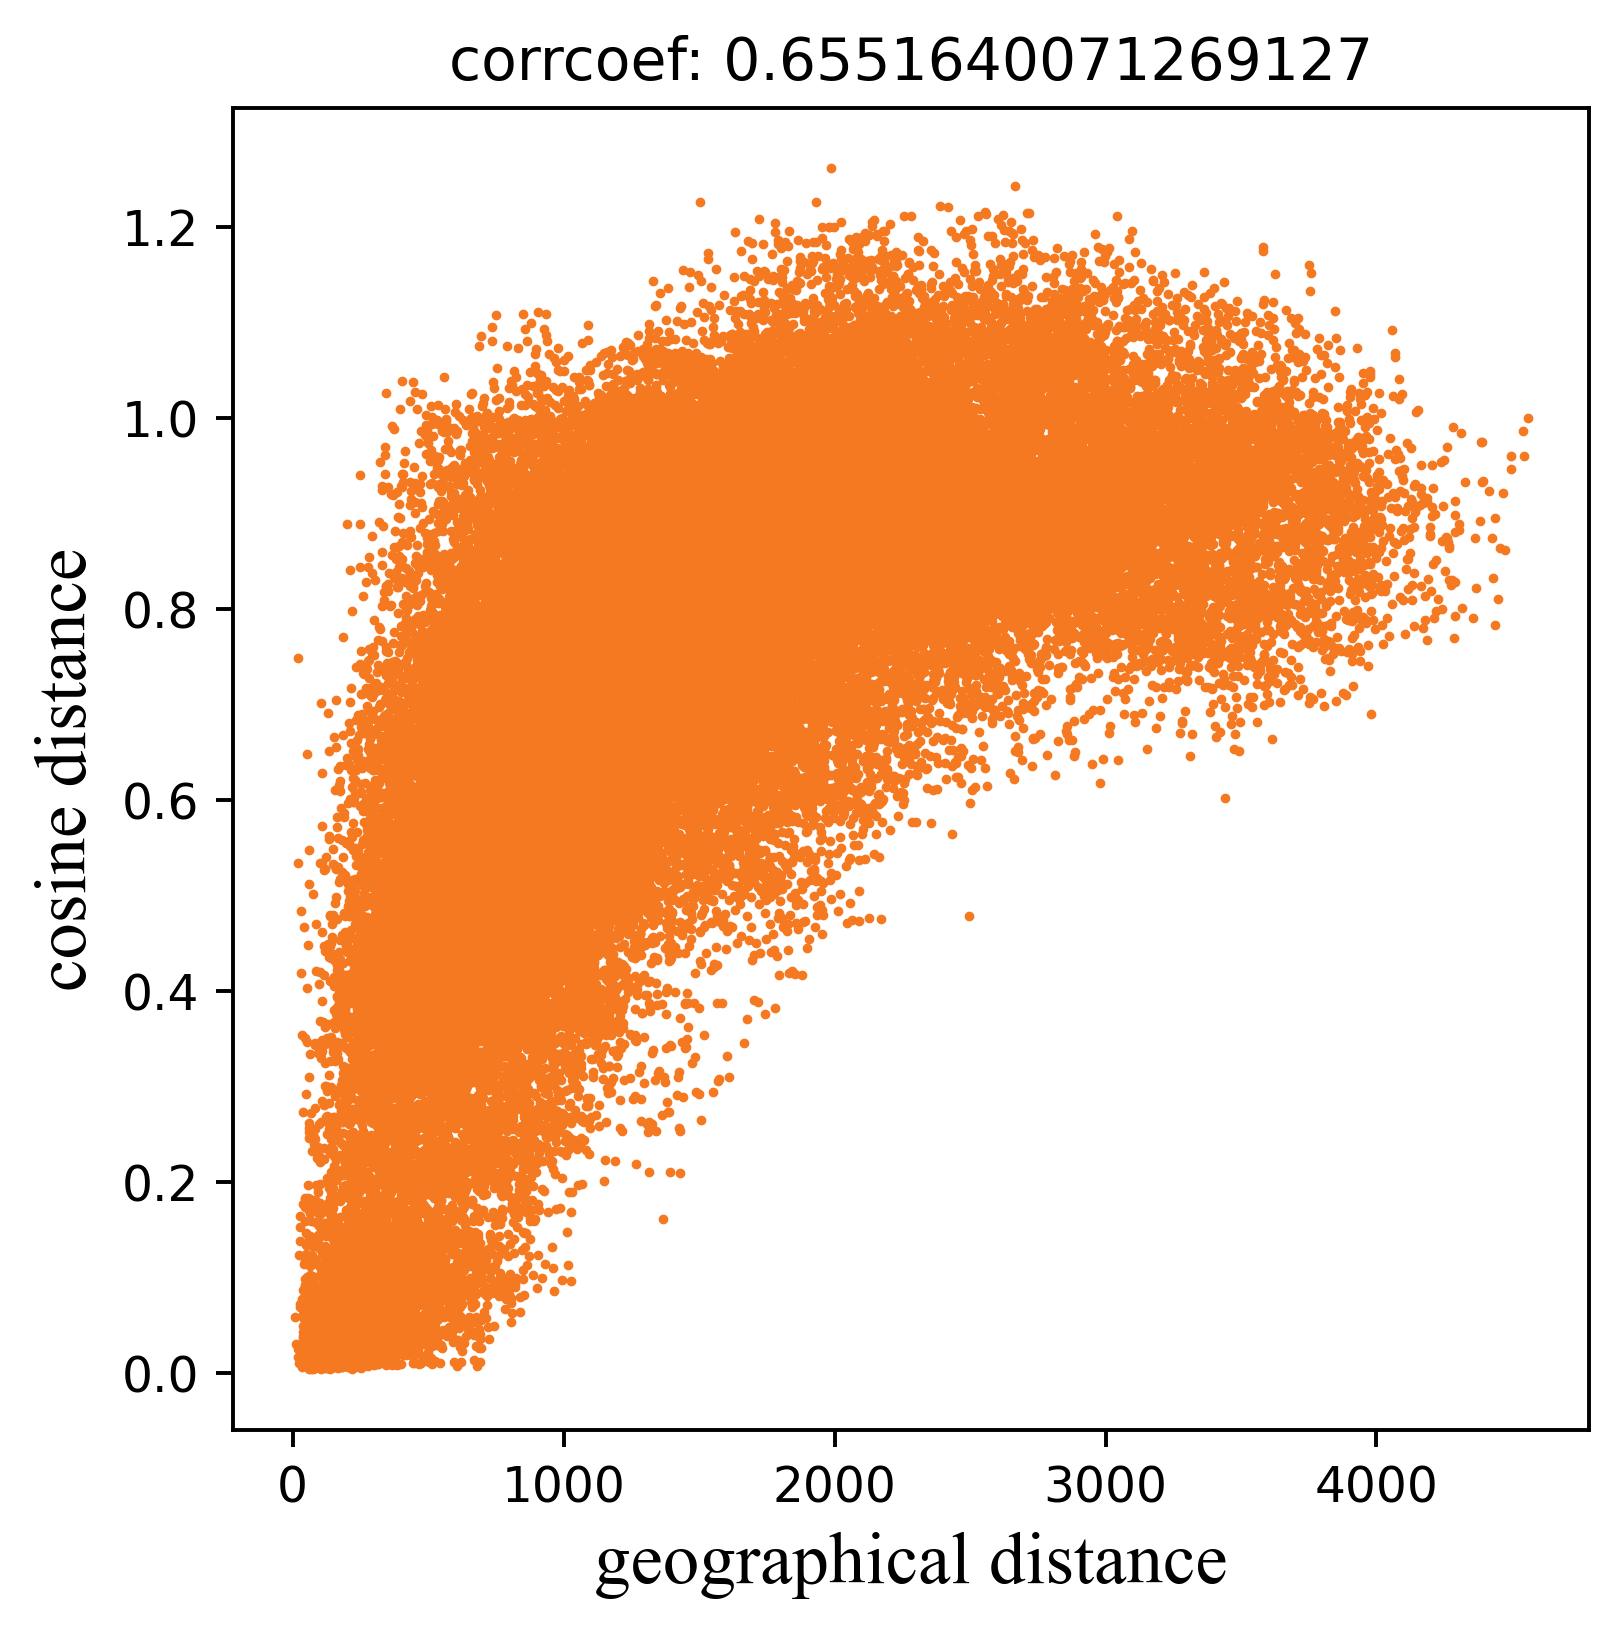

In [54]:
corr_trans = np.zeros((int(n*(n-1)/2),2), dtype=float)
corr_trans[:,0] = corr[:,0]
corr_trans[:,1] = corr[:,1]
figure, axes =plt.subplots(1,1,figsize=(5,5),dpi=350)
ax=axes
ax.set_xlabel("geo_distance")
ax.set_ylabel("cos_distance")
data = pd.DataFrame(corr_trans)
data.columns = ['geo_distance','cos_distance']
data.plot.scatter(x='geo_distance', y='cos_distance', ax=ax, s=1,color='#f47920')
#ax.set_xlim(0,4000)
#ax.set_ylim(0,4000)
axes.set_xlabel("geographical distance", fontdict={'family':'Times New Roman','weight':'normal','size':15})
axes.set_ylabel("cosine distance",fontdict={'family':'Times New Roman','weight':'normal','size':15})
#plt.tick_params(labelsize=15)
coef = np.corrcoef(corr_trans[:,0], corr_trans[:,1])[0][1]
#plt.legend(prop={'size': 30})
plt.title("corrcoef: " + str(coef))

In [55]:
# 导入sklearn库下的linear_model类
from sklearn import linear_model
# 一元线性回归
# 转化自变量数据为矩阵
x = np.expand_dims(np.array(corr[:,0]), axis=1)
y = np.expand_dims(np.array(corr[:,1]), axis=1)

# 调用线性回归函数，让常数项为0
clf = linear_model.LinearRegression(fit_intercept=False)
# 开始线性回归计算
clf.fit(x,y)
# 得到斜率
a = clf.coef_[0]
# 得到截距
b = clf.intercept_
print(a, b)

[0.0004132] 0.0


Text(0.5, 1.0, 'corrcoef: 0.6551640071269121')

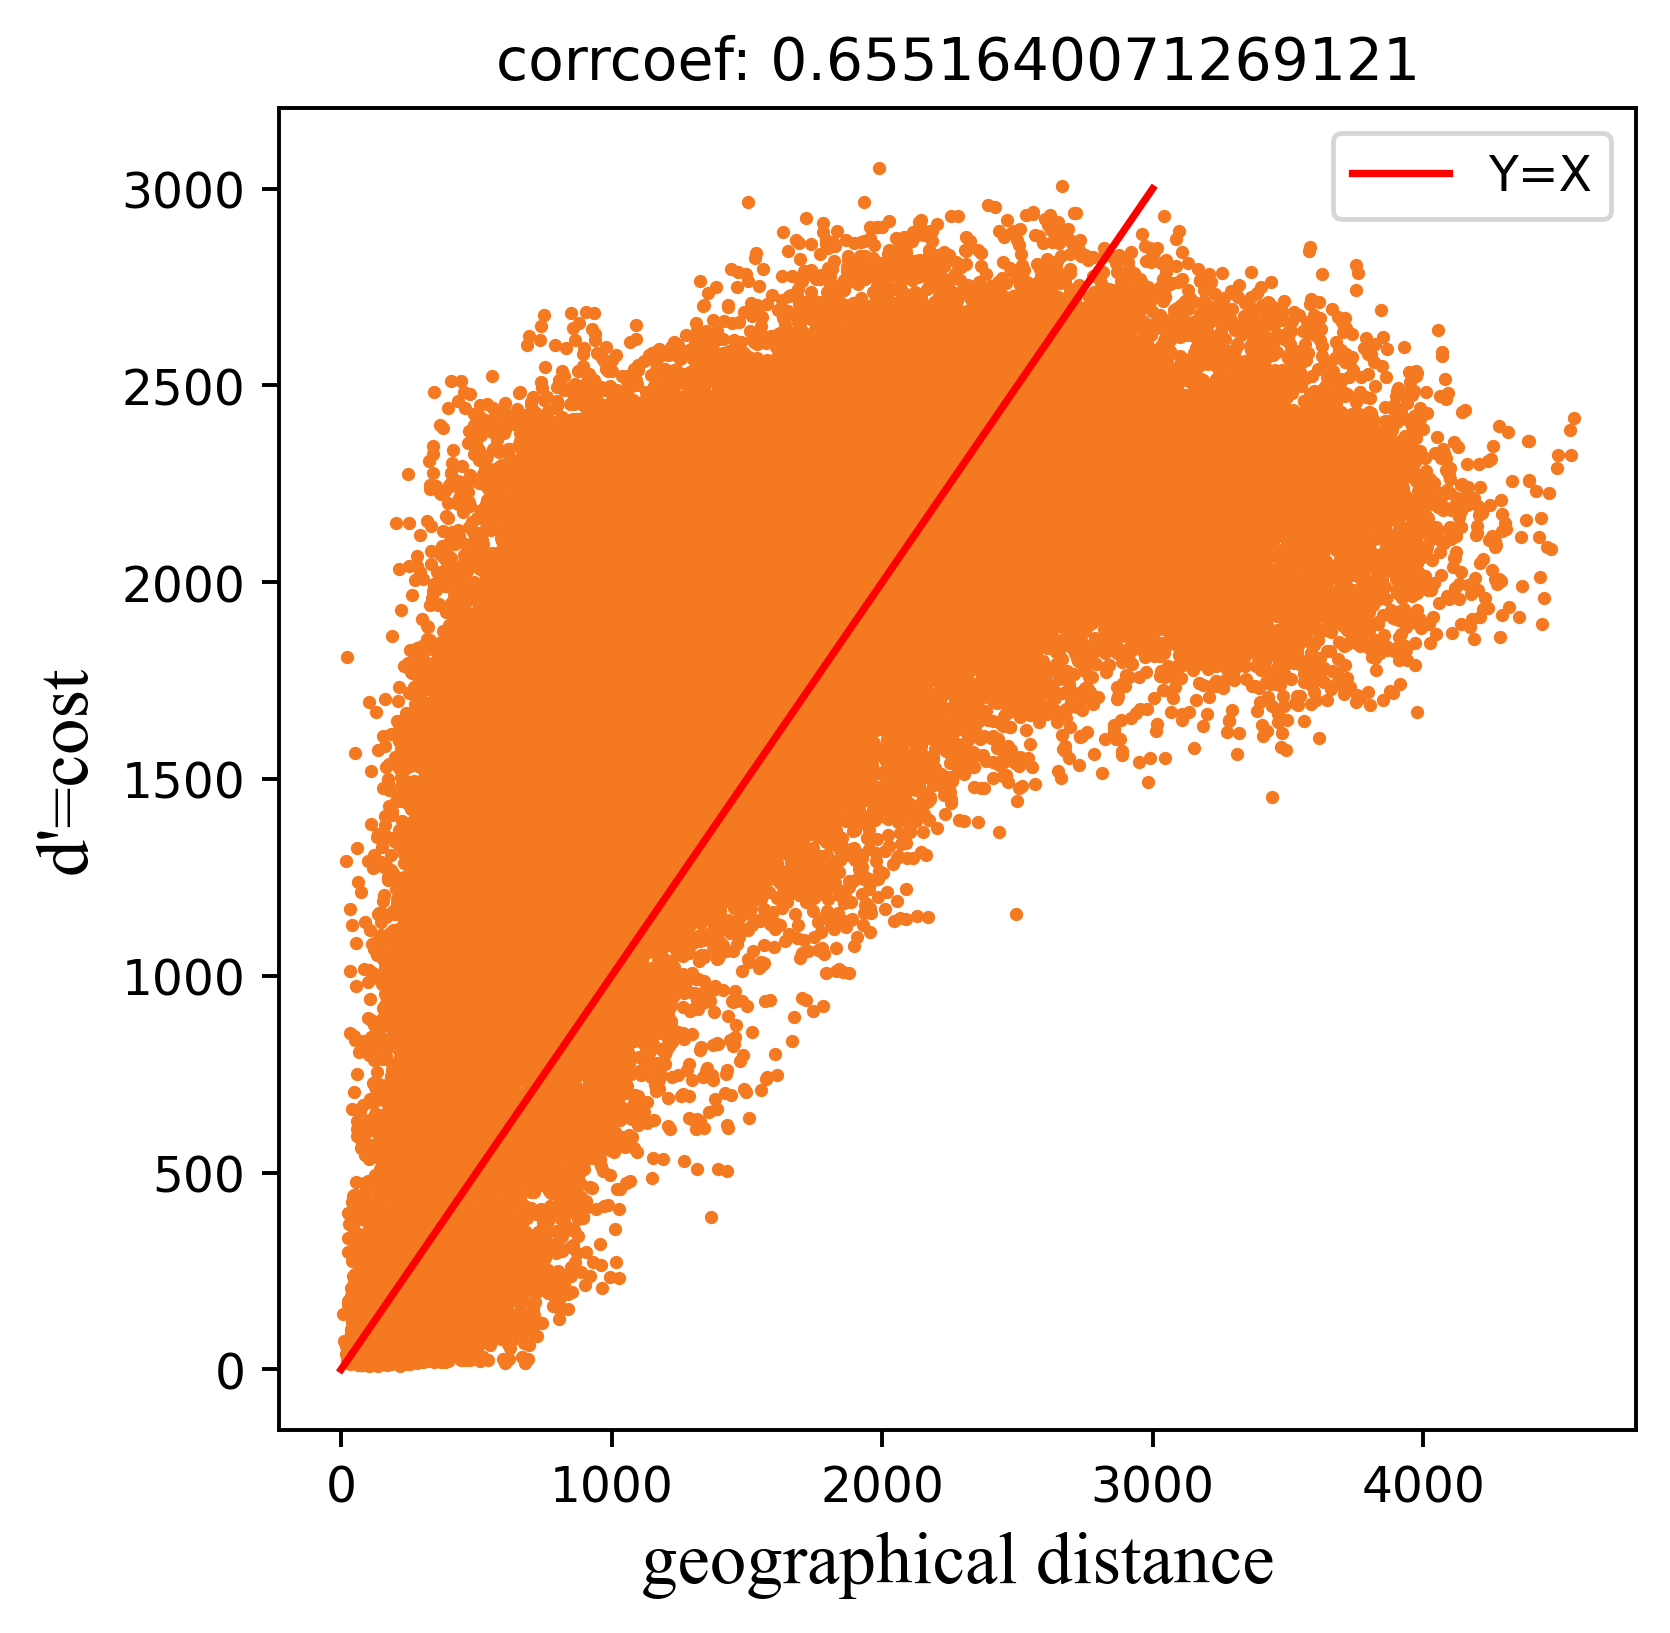

In [56]:
corr_trans = np.zeros((int(n*(n-1)/2),2), dtype=float)
corr_trans[:,0] = corr[:,0]
corr_trans[:,1] = (corr[:,1])/a[0]
figure, axes =plt.subplots(1,1,figsize=(5,5),dpi=350)
ax=axes
ax.set_xlabel("geo_distance")
ax.set_ylabel("cos_distance")
data = pd.DataFrame(corr_trans)
data.columns = ['geo_distance','cos_distance']
data.plot.scatter(x='geo_distance', y='cos_distance', ax=ax, s=3,color='#f47920')
axes.set_xlabel("geographical distance", fontdict={'family':'Times New Roman','weight':'normal','size':15})
axes.set_ylabel("d'=cost",fontdict={'family':'Times New Roman','weight':'normal','size':15})
#plt.tick_params(labelsize=15)

plt.plot([0,3000],[0,3000],color='red',label='Y=X',zorder=1)
plt.legend()
coef = np.corrcoef(corr_trans[:,0], corr_trans[:,1])[0][1]
#plt.legend(prop={'size': 30})
plt.title("corrcoef: " + str(coef))

## 开始应用


In [102]:
from bokeh.io import show, curdoc
from bokeh.models import HoverTool,ColumnDataSource
from bokeh.models import Button, CustomJS, Spinner
from bokeh.plotting import figure
from bokeh.layouts import row, column
import pandas as pd
import numpy as np
from bokeh.palettes import OrRd9
from bokeh.events import ButtonClick

In [99]:
# 流量标准化函数
def T_ij(flow, m):
    # 对流量进行标准化
    flow_re = np.zeros_like(flow)
    j_sum = flow.sum(axis=1)
    for i in range(n):
        flow_re[i,:]= flow[i,:] / j_sum[i] * m[i]
    return flow_re

In [100]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim,
                                       input_length=negative_sample_size+1,
                                       name="w2v_context")

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [101]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [98]:
# 提前数据准备
flow = np.load(r"./data/data_avg.npy")
m = flow.sum(axis=1)
# 让每一行的数据归一化
data = pd.DataFrame(flow)
data = data.apply(lambda r:r/r.sum(), axis=1)

# 再计算累积分布
data_cum = np.array(data)
for i in range(1, data_cum.shape[1]):
    data_cum[:,i] = data_cum[:, i-1]+data_cum[:,i]
#pd.DataFrame(data_cum)

# 起点
start_cum= m / m.sum()
for i in range(1, start_cum.shape[0]):
    start_cum[i] = start_cum[i]+start_cum[i-1]

np.random.seed(486626)
targets = [] #(n,)
postive_context = [] #(n,)
target_size = 100000
starts = random.uniform(size=(target_size,2))

In [103]:
# 调参应用 参数有：1 目标数量， 2 每个目标应用的负样本数量（正样本数量默认为1）3 向量维度 4 训练迭代次数
spinner_target = Spinner(title="Target Siz:", low=10000, high=120000, step=5000, value=60000, format="0,0")
spinner_negative = Spinner(title="Negative Sample Size:", low=1, high=10, step=1, value=5)
spinner_dimension = Spinner(title="Dimension Size:", low=10, high=150, step=10, value=80)
spinner_epoch = Spinner(title="Epochs:", low=1, high=5, step=1, value=1)
button_train = Button(label='Get Vector',button_type="primary")

def train():
    # 获取参数
    target_size = spinner_target.value
    negative_sample_size = spinner_negative
    
    # 正样本采样
    for i in range(target_size):
        targets.append(np.searchsorted(start_cum, starts[i][0]))
        postive_context.append(np.searchsorted(data_cum[targets[i]], starts[i][1]))
    
    data_reconstruct = np.zeros((n,n),dtype=float)
    for i in range(target_size):
        data_reconstruct[targets[i]][postive_context[i]]+=1
    # 流量标准化
    data_reconstruct_re = T_ij(data_reconstruct, m)
    # 画出相关性图
    if p1.renderers != []:
        p1.renderers.pop()
    p1.circle(y=data_reconstruct_re.flatten(), x=flow.flatten(),color='red',size=3)
        
    start_cum_negative = np.array([m]*vocab_size)
    start_cum_negative = np.where(data_reconstruct_re==0, start_cum_negative, 0)
    for i in range(vocab_size):
        start_cum_negative[i][i]=0
    # 让每一行的数据归一化
    start_cum_negative = pd.DataFrame(start_cum_negative)
    start_cum_negative = start_cum_negative.apply(lambda r:r/r.sum(), axis=1)

    # 再计算累积分布
    start_cum_negative = np.array(start_cum_negative)
    for i in range(1, start_cum_negative.shape[1]):
        start_cum_negative[:,i] = start_cum_negative[:, i-1]+start_cum_negative[:,i]

    # 负样本采样
    
    negative_context = []
    rand = random.uniform(size=(target_size,negative_sample_size))
    for i in range(target_size):
        negative_context_i = []
        for j in range(negative_sample_size):
            negative_context_temp = np.searchsorted(start_cum_negative[targets[i]], rand[i][j])
            negative_context_i.append(negative_context_temp)
        negative_context.append(negative_context_i)
    # 构建完整训练集
    labels = []
    contexts = []
    for i in range(target_size):
        contexts.append([postive_context[i]] + negative_context[i])
        labels.append([1]+[0]*negative_sample_size)

    # 训练数据预处理
    SEED = 486626
    AUTOTUNE = tf.data.AUTOTUNE

    BATCH_SIZE = 128
    BUFFER_SIZE = 10000
    targets_use = np.array(targets, dtype='float32')
    contexts_use = np.array(contexts, dtype='float32')
    labels_use = np.array(labels, dtype='float32')
    dataset = tf.data.Dataset.from_tensor_slices(((targets_use, contexts_use), labels_use))
    dataset = dataset.shuffle(BUFFER_SIZE,seed=SEED).batch(BATCH_SIZE, drop_remainder=True)
    print(dataset)

    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # 更换损失函数
    embedding_dim = spinner_dimension.value
    vocab_size = len(m)
    word2vec = Word2Vec(vocab_size, embedding_dim)
    word2vec.compile(optimizer='adam',
                    loss=custom_loss,
                    metrics=['accuracy'])
    word2vec.fit(dataset, epochs=spinner_epoch.value)

button_train.on_event(ButtonClick, train)
# 正样本采样和原始网络的散点图
p1 = figure(background_fill_color="lightgrey")

curdoc().add_root(column(row(column(spinner_target,spinner_negative),column(spinner_dimension,spinner_epoch)),button_train,p1))


You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html

